In [1]:
import straxen
import strax
from multihist import Hist1d, Histdd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from tqdm import tqdm

%run /home/tzpmb0714/ini/initialize_plot.ipynb
#st = straxen.contexts.demo()
st = straxen.contexts.strax_workshop_dali()
straxen.download_test_data()

In [74]:
run_id = tuple(st.select_runs(include_tags='spe_topring').name.values)

In [81]:
!pwd

/home/tzpmb0714/analysis/STRAX/strax_tutorials


In [75]:
df = st.get_array(run_id, 'raw_records', seconds_range=(0, 4))

Not saving raw_records while selecting a time range in the run


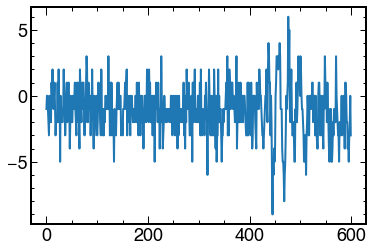

In [12]:
plt.plot(df['data'][7])
plt.show()

In [77]:
def gaus(x, a, mu, sig, const):
    return a*np.exp(-0.5*(x-mu)**2/sig**2)+const

In [78]:
info = {
    'mean': [],
    'sig': [],
    'pmt': []
}
n_chanel_s = np.arange(0, 254, 1)
# pmts_rejected = [1, 2, 26, 62, 65, 79, 88, 102, 118, 130, 134, 135, 137, 139, 
#  150, 152, 162, 178, 183, 198, 206, 213, 214, 234, 239, 244]
hit_pattern = []

for n_channel in tqdm(n_chanel_s):
#     if n_channel in pmts_rejected:
#         continue
    #n_channel = 0
    df_tmp = df[df['channel'] == n_channel]
    amp = []
    for df_ in df_tmp:
        amp.append(np.max(df_['data']))
    amp = np.array(amp)

    hist = Hist1d(amp, bins=np.linspace(0, 200, 100))

    # fit amp
    mask = (hist.bin_centers > 30) & (hist.bin_centers < 200)
    popt, pcov = curve_fit(gaus, hist.bin_centers[mask], hist.histogram[mask], 
                           p0=[10, 60, 20, 0], maxfev=int(1e6))
    # plot?
    #     hist.plot()
    #     x = np.linspace(30, 200, 100)
    #     plt.plot(x, gaus(x, *popt), 'r-', label='Mean: %.1f\nStd: %.1f' %(popt[1], popt[2]))
    #     plt.title('Channel %d' %n_channel)
    #     plt.yscale('log')
    #     plt.legend(loc='best')
    #     plt.show()

    mean, sig = popt[1], popt[2]
    info['mean'].append(popt[1])
    info['sig'].append(popt[2])
    info['pmt'].append(n_channel)

    mask = (amp < mean + sig) & (amp > mean - sig)
    hit_pattern.append(df_tmp[mask]['data'].sum(axis=0))
    #hit_pattern.append(mask.sum(axis=0))
    
    #hit_pattern.append(df[mask])

 11%|█         | 28/254 [00:00<00:08, 26.69it/s]/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.6/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 254/254 [00:10<00:00, 24.73it/s]


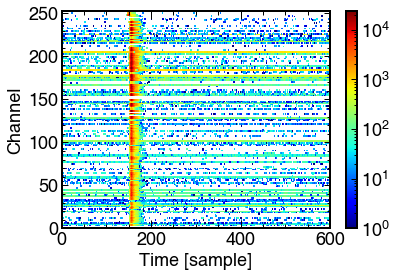

In [79]:
time = np.arange(0, 600, 1)
channel = np.arange(0, 254, 1)
time_grid, channel_grid = np.meshgrid(time, channel)
plt.pcolormesh(time_grid, channel_grid, hit_pattern, norm=LogNorm())
plt.xlabel('Time [sample]')
plt.ylabel('Channel')
plt.colorbar()
plt.show()

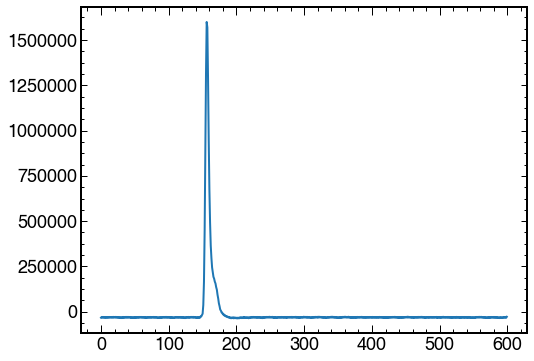

In [199]:
plt.plot(time, np.array(hit_pattern).sum(axis=0))
#plt.yscale('log')
#plt.ylim(1,)
plt.show()

## Get amplitude distribution from LED and Noise run

### Get amplitude using hardcoded way...

In [3]:
run_id_led = tuple(st.select_runs(include_tags='spe_topring').name.values)
arr_led = st.get_array(run_id_led, 'raw_records', seconds_range=(0, 40))

Not saving raw_records while selecting a time range in the run


In [4]:
run_id_noise = st.select_runs(include_tags='gain_step4')['name'].values[0]  # gain_step4
arr_noise = st.get_array(run_id_noise, 'raw_records', seconds_range=(0, 40))

Not saving raw_records while selecting a time range in the run


In [5]:
def get_amp(df, channel):
    df_tmp = df[df['channel'] == channel]
    amp = []
    for df_ in df_tmp['data']:
        amp.append(np.max(df_[125:250]))  # hardcoded for now
    return amp

In [11]:
channel = 10
amp_led = get_amp(arr_led, channel=channel)
amp_noise = get_amp(arr_noise, channel=channel)

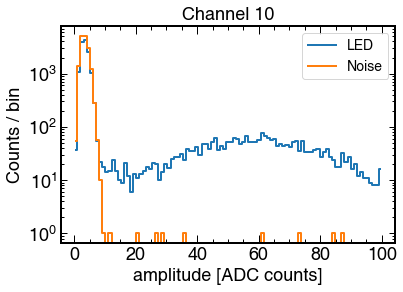

In [12]:
hist_led = Hist1d(amp_led, bins=np.linspace(0, 100, 100))
hist_led.plot(label='LED')
hist_noise = Hist1d(amp_noise, bins=np.linspace(0, 100, 100))
hist_noise.plot(label='Noise')
plt.yscale('log')
plt.legend(loc='best')
plt.xlabel('amplitude [ADC counts]')
plt.ylabel('Counts / bin')
plt.title('Channel %d' %channel)
plt.show()

Noise spectrum is not normalized yet so the residual plot below looks weird.

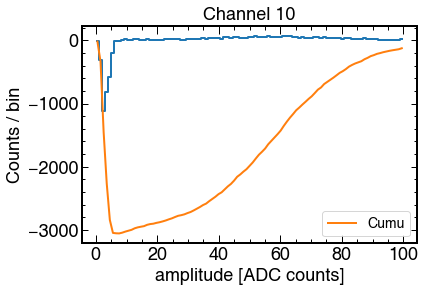

In [15]:
hist_res = Hist1d(bins=np.linspace(0, 100, 100))
hist_res.add(hist_led.bin_centers, hist_led.histogram - hist_noise.histogram)
hist_res.plot()
#plt.yscale('log')
plt.plot(hist_res.bin_centers, hist_res.cumulative_histogram, label='Cumu')
plt.xlabel('amplitude [ADC counts]')
plt.ylabel('Counts / bin')
plt.legend(loc='best')
plt.title('Channel %d' %channel)
plt.show()

### Get amplitude from 'LEDCal' plugin

In [45]:
# import numba

# @numba.njit
def get_amplitude(raw_records, window, dtype):
    ret = []
    for r in raw_records:
        wf = r['data'][window[0]:window[1]]
        amp = wf.max()
        ret.append((amp, r['channel'], r['time'], r['dt'], r['length']))  # , , 
    ret = np.array(ret, dtype=dtype)
    return ret

#@export
@strax.takes_config(
    strax.Option(
        'LED_window',
        default=(125, 250),
        help="Window (samples) where we expect signal in LED calibration"))

class LEDCal(strax.Plugin):
    __version__ = '0.0.1'

    depends_on = ('raw_records',)
    #data_kind = 'led_cal'
    compressor = 'zstd'
    parallel = 'process'
    rechunk_on_save = False
    dtype = [('amplitude', np.int32, 'Amplitude in LED window'),
             ('channel', np.int16, 'Channel'),
             ('time', np.int64, 'Start time of the interval (ns since unix epoch)'),
             ('dt', np.int16, 'Time resolution in ns'),
             ('length', np.int32, 'Length of the interval in samples')
            ]

    def compute(self, raw_records):
        # Remove records from funny channels (if present)
        r = raw_records[raw_records['channel'] < 248] # hardcoded for now
        
        return get_amplitude(r, self.config['LED_window'], self.dtype)

In [46]:
ctext = straxen.contexts.strax_workshop_dali()
ctext.register(LEDCal)
ctext.data_info('led_cal')

,Field name,Data type,Comment
0,amplitude,int32,Amplitude in LED window
1,channel,int16,Channel
2,time,int64,Start time of the interval (ns since unix epoch)
3,dt,int16,Time resolution in ns
4,length,int32,Length of the interval in samples


Have to make data first before using `seconds_range` when getting array.

In [25]:
arr_tmp = ctext.make(run_id_led, 'led_cal')
arr_tmp = ctext.make(run_id_noise, 'led_cal')

In [49]:
arr_led = ctext.get_array(run_id_led, 'led_cal', seconds_range=(0, 40))  # , seconds_range=(0, 4)

Not saving led_cal while selecting a time range in the run


In [50]:
arr_noise = ctext.get_array(run_id_noise, 'led_cal', seconds_range=(0, 40))  # , seconds_range=(0, 4)

Not saving led_cal while selecting a time range in the run


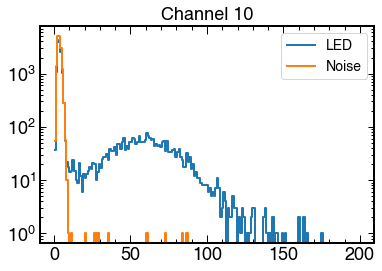

In [80]:
channel = 10
mask = arr_led['channel'] == channel
hist_led = Hist1d(arr_led['amplitude'][mask], bins=np.linspace(0, 200, 200))
hist_led.plot(label='LED')
mask = arr_noise['channel'] == channel
hist_noise = Hist1d(arr_noise['amplitude'][mask], bins=np.linspace(0, 200, 200))
hist_noise.plot(label='Noise')
plt.yscale('log')
plt.title('Channel %d' %channel)
plt.legend(loc='best')
plt.show()

Normalize the noise spectrum in the plot below.

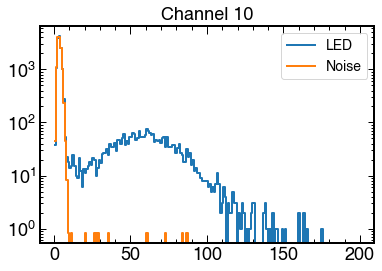

In [62]:
channel = 10
mask = arr_led['channel'] == channel
hist_led = Hist1d(arr_led['amplitude'][mask], bins=np.linspace(0, 200, 200))
hist_led.plot(label='LED')
mask = arr_noise['channel'] == channel
hist_noise = Hist1d(arr_noise['amplitude'][mask], bins=np.linspace(0, 200, 200))
hist_noise.histogram = hist_noise.histogram * (hist_led.cumulative_histogram[7] / hist_noise.cumulative_histogram[7])

hist_noise.plot(label='Noise')
plt.yscale('log')
plt.title('Channel %d' %channel)
plt.legend(loc='best')
plt.show()

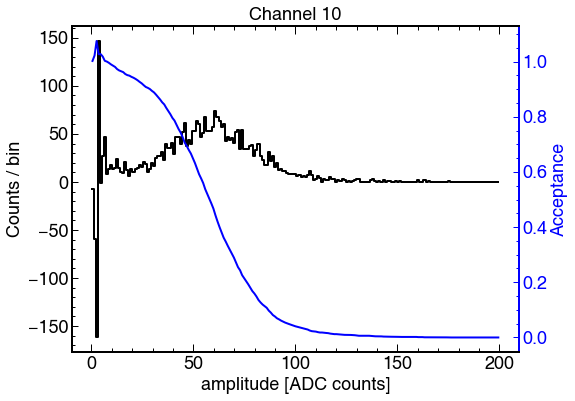

In [73]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

hist_res = hist_led - hist_noise
hist_res.plot(color='black')
plt.xlabel('amplitude [ADC counts]')
plt.ylabel('Counts / bin')

ax2 = ax.twinx()
cdf = hist_res.cumulative_histogram
plt.plot(hist_led.bin_centers, 1 - cdf / cdf[-1], color='blue')
plt.ylabel('Acceptance', color='blue')
ax2.tick_params(axis='y', colors='blue', which='both')
ax2.spines['right'].set_color('blue')

plt.title('Channel %d' %channel)
plt.show()

In [22]:
ctext.data_info('raw_records')

,Field name,Data type,Comment
0,channel,int16,Channel/PMT number
1,dt,int16,Time resolution in ns
2,time,int64,Start time of the interval (ns since unix epoch)
3,length,int32,Length of the interval in samples
4,area,int32,Integral in ADC x samples
5,pulse_length,int32,Length of pulse to which the record belongs (w...
6,record_i,int16,Fragment number in the pulse
7,baseline,float32,Baseline in ADC counts. data = int(baseline) -...
8,reduction_level,uint8,Level of data reduction applied (strax.Reducti...
9,data,"('<i2', (110,))",Waveform data in ADC counts above baseline
